# Sampling the Solution over a Line
Let us revisit our simple 3d example from the introduction

In [1]:
from matplotlib import pyplot
import numpy
try:
    import pygmsh
    with pygmsh.geo.Geometry() as geom:
        poly = geom.add_polygon([
              [ 0.0,  0.5, 0.0], [-0.1,  0.1, 0.0], [-0.5,  0.0, 0.0],
              [-0.1, -0.1, 0.0], [ 0.0, -0.5, 0.0], [ 0.1, -0.1, 0.0],
              [ 0.5,  0.0, 0.0], [ 0.1,  0.1, 0.0] ], mesh_size=0.05)
        geom.twist(
            poly,
            translation_axis=[0, 0, 1], rotation_axis=[0, 0, 1], point_on_axis=[0, 0, 0],
            angle=numpy.pi / 3,
        )
        mesh = geom.generate_mesh(verbose=False)

    points, cells = mesh.points, mesh.cells_dict
    domain3d = {"vertices":points.astype("float"), "simplices":cells["tetra"]}
except ImportError: # pygmsh not installed - use a simple cartesian domain
    print("pygmsh module not found using a simple Cartesian domain - ignored")
    from dune.grid import cartesianDomain
    domain3d = cartesianDomain([-0.25,-0.25,0],[0.25,0.25,1],[30,30,60])

from dune.alugrid import aluSimplexGrid as leafGridView3d
gridView3d  = leafGridView3d(domain3d)

As before we solve a simple Laplace problem

In [2]:
from dune.fem.space import lagrange as solutionSpace
from dune.fem.scheme import galerkin as solutionScheme
from ufl import TrialFunction, TestFunction, SpatialCoordinate, dot, grad, dx, conditional, sqrt

space3d = solutionSpace(gridView3d, order=1)
u = TrialFunction(space3d)
v = TestFunction(space3d)
x = SpatialCoordinate(space3d)
scheme3d = solutionScheme((dot(grad(u),grad(v))+u*v)*dx ==
                        conditional(dot(x,x)<.01,100,0)*v*dx,
                        solver='cg')
uh3d = space3d.interpolate([0],name="solution")
info = scheme3d.solve(target=uh3d)

Instead of plotting this using paraview we want to only study the
solution along a single line. This requires findings points
$x_i = x_0+\frac{i}{N}(x1-x0)$ for $i=0,\dots,N$ within the unstructured
grid. This would be expensive to compute on the Python so we implement
this algorithm in C++ using the `LineSegmentSampler` class available in
`Dune-Fem`. The resulting `algorithm` returns a pair of two lists with
coordinates $x_i$ and the values of the grid function at these points:

.. literalinclude:: utility.hh


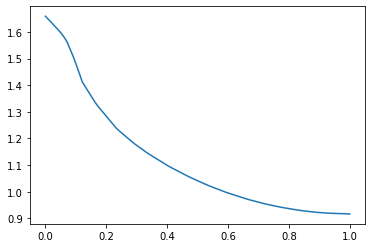

In [3]:
import dune.generator.algorithm as algorithm
from dune.common import FieldVector
x0, x1 = FieldVector([0,0,0]), FieldVector([0,0,1])
p,v = algorithm.run('sample', 'utility.hh', uh3d, x0, x1, 100)
x,y = numpy.zeros(len(p)), numpy.zeros(len(p))
length = (x1-x0).two_norm
for i in range(len(x)):
    x[i] = (p[i]-x0).two_norm / length
    y[i] = v[i][0]
pyplot.plot(x,y)

**Note**: the coordinates returned are always in the interval $[0,1]$ so
if physical coordinates are required, they need to be rescaled.
Also, function values returned by the `sample` function
are always of a `FieldVector` type, so that even for a scalar example
a `v[i]` is a vector of dimension one, so that `y[i]=v[i][0]` has to be
used.

A mentioned above any grid function can be passed in as argument to the
`sample` function. So for example plotting $|\nabla u_h|$ is straight
forward using the corresponding ufl expression. Since in this case
automatic conversion from the ufl expression (available for example in the
plotting function) to a grid function, we need to do this explicitly:

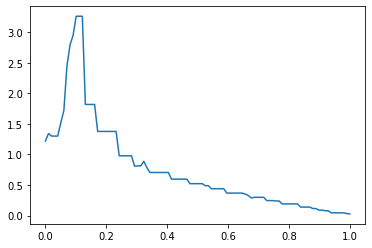

In [4]:
from dune.ufl import expression2GF
absGrad = expression2GF(gridView3d, sqrt(dot(grad(uh3d),grad(uh3d))), 2 )
p,v = algorithm.run('sample', 'utility.hh', absGrad, x0, x1, 100)
for i in range(len(x)):
    y[i] = v[i][0]
pyplot.plot(x,y)

Similar we can plot both partial derivatives of the solution over the
given line:

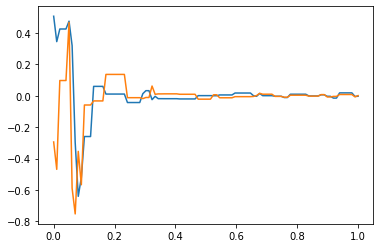

In [5]:
from dune.ufl import expression2GF
absGrad = expression2GF(gridView3d, grad(uh3d), 2 )
p,v = algorithm.run('sample', 'utility.hh', absGrad, x0, x1, 100)
dx,dy = numpy.zeros(len(p)), numpy.zeros(len(p))
for i in range(len(x)):
    dx[i] = v[i][0]
    dy[i] = v[i][1]
pyplot.plot(x,dx)
pyplot.plot(x,dy)

**Remark:** plotting over a line has been included as a utility function
so can easily be called as shown below

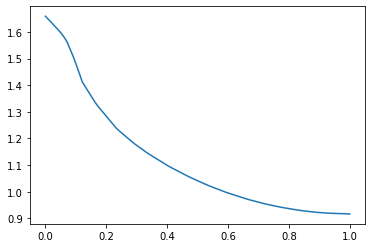

In [6]:
from dune.fem.utility import lineSample
x,y = lineSample(uh3d,[0,0,0],[0,0,1],100)
pyplot.plot(x,y)